# Multi-Stage Stochastic Vehicle-Target Assignment with Equilibrium Selection Framework 

## Initial Game Setup:

### Initializations:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters Initialization
H = 20  # Number of stages (time horizon)
N = 25     # Number of vehicles (agents)
S = 200    # Number of targets (states)
gamma = 0.9  # Discount factor
temperature = 0.9  # Temperature parameter for softmax

# Dynamic Type Assignment Functions
def assign_vehicle_types(N):
    """Randomly assign vehicle types."""
    return np.random.choice(["light", "heavy"], size=N)

def assign_target_types(S):
    """Randomly assign target types."""
    return np.random.choice(["weak", "medium", "strong"], size=S)

# Dynamically Assign Types
vehicle_types = assign_vehicle_types(N)
target_types = assign_target_types(S)

# Count of Target Types
unique, counts = np.unique(target_types, return_counts=True)
target_class_counts = dict(zip(unique, counts))
print("Target Class Counts:", target_class_counts)

# Compatibility Matrix and Reward Matrix
def custom_reward_matrix(vehicle_types, target_types, N, S):
    """Create a reward matrix based on vehicle-target compatibility."""
    rewards = np.zeros((N, S))
    for i in range(N):
        for j in range(S):
            if vehicle_types[i] == "light" and target_types[j] == "weak":
                rewards[i, j] = 10
            elif vehicle_types[i] == "light" and target_types[j] == "medium":
                rewards[i, j] = 7
            elif vehicle_types[i] == "heavy" and target_types[j] == "strong":
                rewards[i, j] = 12
            elif vehicle_types[i] == "heavy" and target_types[j] == "medium":
                rewards[i, j] = 6
            else:
                rewards[i, j] = 0  # Incompatible pair, hence 0 reward
    return rewards

# Initialize Q-values, V-values, and auxiliary variables
Q = np.random.uniform(low=-1, high=1, size=(N, S, H))  # Random small initial Q(s, a, h)
V = np.zeros((N, S, H + 1))  # Initialize V(s, h)
policy = np.ones((N, S, S, H)) / S  # Initial policy: Uniform distribution
rewards = custom_reward_matrix(vehicle_types, target_types, N, S)  # Reward matrix
target_available = np.ones(S, dtype=bool)  # Availability tracker for targets
global_utility = np.zeros(H)  # Global utility
vehicle_utility = np.zeros((N, H))  # Cumulative reward for each vehicle

# Terminal Stage Initialization for V(s, H + 1)
V[:, :, -1] = 0  # Terminal stage values set to 0

# Transition Probabilities
def generate_transition_probabilities(N, S):
    """Generate random uniform transition probabilities P(s' | s, a)."""
    transition_probabilities = np.random.uniform(size=(N, S, S))
    # Normalize to ensure probabilities sum to 1 for each (s, a)
    transition_probabilities = transition_probabilities / transition_probabilities.sum(axis=-1, keepdims=True)
    return transition_probabilities

transition_probabilities = generate_transition_probabilities(N, S)
print("Transition Probabilities:", transition_probabilities)


Target Class Counts: {'medium': 62, 'strong': 64, 'weak': 74}
Transition Probabilities: [[[0.00339803 0.00458453 0.00999562 ... 0.00903724 0.00770761 0.00321906]
  [0.00834546 0.00282549 0.00304201 ... 0.00320332 0.00939545 0.00310666]
  [0.0059046  0.00934846 0.00964639 ... 0.00515504 0.00915284 0.00672698]
  ...
  [0.00031255 0.00139793 0.00617162 ... 0.0079573  0.00870533 0.01020561]
  [0.00171035 0.00724839 0.00347149 ... 0.00692655 0.00702709 0.00380492]
  [0.00751443 0.00189084 0.00020925 ... 0.00310622 0.00996623 0.00711798]]

 [[0.00549408 0.00194371 0.0091492  ... 0.00707732 0.00886149 0.00518472]
  [0.00946568 0.00476008 0.00155136 ... 0.00870525 0.00797355 0.00714011]
  [0.00651596 0.00382757 0.00388465 ... 0.00361751 0.00178766 0.00016164]
  ...
  [0.00159255 0.00339037 0.00624698 ... 0.00834442 0.00751013 0.00544972]
  [0.00241384 0.00194755 0.0074764  ... 0.00976848 0.00723    0.00771017]
  [0.0042546  0.00748367 0.00482427 ... 0.00145802 0.00684256 0.00805759]]

 [[0.004

## Helper Functions:
### 1. Softmax Policy

In [20]:
# Compatibility Check Function
def is_compatible(vehicle_type, target_type):
    """Check if a vehicle and target are compatible."""
    if (vehicle_type == "light" and target_type == "strong") or \
       (vehicle_type == "heavy" and target_type == "weak"):
        return False
    return True

# Softmax Policy Function
def softmax_policy(Q_values, target_available, temperature):
    """Compute softmax probabilities."""
    Q_values[~target_available] = -np.inf  # Exclude unavailable targets
    exp_values = np.exp(Q_values / temperature)
    probabilities = exp_values / (np.sum(exp_values) + 1e-10)
    if np.sum(probabilities) == 0 or np.any(np.isnan(probabilities)):
        probabilities = np.ones_like(Q_values) / len(Q_values)  # Uniform distribution
    return probabilities

# Sample Action Function
def sample_action(probabilities):
    """Sample action based on probabilities."""
    return np.random.choice(len(probabilities), p = probabilities)

## Main Algorithm:

In [21]:
# Main Loop
epsilon = 1e-4  # Convergence threshold for Q-values (you can adjust this)
for t in range(H):
    print(f"Stage {t + 1}:")
    stage_reward = 0  # Track total reward for this stage

    # Check if all targets are assigned
    if not np.any(target_available):
        print("All targets have been acquired. Ending game early.")
        break

    Q_previous = Q.copy()  # Store previous Q-values to check for convergence
    
    for vehicle in range(N):
        # Step 1 (Actor): Select action using softmax policy
        action_distribution = softmax_policy(Q[vehicle, :, t], target_available, temperature)
        action = sample_action(action_distribution)

        # Skip if no valid action is available
        if not target_available[action]:
            print(f"  Vehicle {vehicle} has no valid targets to select.")
            vehicle_utility[vehicle, t] = vehicle_utility[vehicle, max(t - 1, 0)]  # Retain previous utility
            continue

        # Check compatibility
        if not is_compatible(vehicle_types[vehicle], target_types[action]):
            print(f"  Vehicle {vehicle} ({vehicle_types[vehicle]}) incompatible with Target {action} ({target_types[action]}). Skipping assignment.")
            vehicle_utility[vehicle, t] = vehicle_utility[vehicle, max(t - 1, 0)]  # Retain previous utility
            continue

        # Step 2: Get reward for compatible assignment
        reward = rewards[vehicle, action]
        stage_reward += reward
        vehicle_utility[vehicle, t] = vehicle_utility[vehicle, max(t - 1, 0)] + reward

        # Mark target as unavailable
        target_available[action] = False

        # Step 3 (Critic): Update Q and V values
        if t < H - 1:
            # Update Q-value based on probabilistic transitions (Algorithm 1)
            next_state_values = np.dot(transition_probabilities[vehicle, action], V[vehicle, :, t + 1])
            Q[vehicle, action, t] = reward + gamma * next_state_values
        else:
            Q[vehicle, action, t] = reward  # Terminal stage

        # Update V using cumulative averaging (Algorithm 1)
        V[vehicle, :, t] = (t * V[vehicle, :, t] + Q[vehicle, action, t]) / (t + 1)

        print(f"  Vehicle {vehicle} ({vehicle_types[vehicle]}) assigned to Target {action} ({target_types[action]}) | Reward: {reward:.2f} | Updated Q: {Q[vehicle, action, t]:.2f}")

    # Update global utility
    global_utility[t] = global_utility[max(t - 1, 0)] + stage_reward
    print(f"  Global Utility at Stage {t + 1}: {global_utility[t]:.2f}\n")

    # Check for Q-value convergence (equilibrium)
    # Check if Q or Q_previous contain NaN or inf values, replace with 0 if they do
    Q = np.nan_to_num(Q, nan=0.0, posinf=0.0, neginf=0.0)
    Q_previous = np.nan_to_num(Q_previous, nan=0.0, posinf=0.0, neginf=0.0)

    max_change = np.max(np.abs(Q - Q_previous))  # Check maximum change in Q-values
    if max_change < epsilon:
        print(f"Equilibrium reached (Q-values converged). Ending game early.")
        break

# Extract Optimal Policies
optimal_policy = np.zeros((N, S), dtype=int)
for i in range(N):
    for s in range(S):
        optimal_policy[i, s] = np.argmax(Q[i, :, H - 1])

print("Optimal policies for all vehicles:", optimal_policy)


Stage 1:
  Vehicle 0 (heavy) assigned to Target 113 (medium) | Reward: 6.00 | Updated Q: 6.00
  Vehicle 1 (heavy) assigned to Target 12 (medium) | Reward: 6.00 | Updated Q: 6.00
  Vehicle 2 (light) assigned to Target 63 (medium) | Reward: 7.00 | Updated Q: 7.00
  Vehicle 3 (light) incompatible with Target 26 (strong). Skipping assignment.
  Vehicle 4 (light) assigned to Target 89 (weak) | Reward: 10.00 | Updated Q: 10.00
  Vehicle 5 (heavy) assigned to Target 83 (medium) | Reward: 6.00 | Updated Q: 6.00
  Vehicle 6 (light) assigned to Target 92 (weak) | Reward: 10.00 | Updated Q: 10.00
  Vehicle 7 (light) assigned to Target 28 (medium) | Reward: 7.00 | Updated Q: 7.00
  Vehicle 8 (light) assigned to Target 75 (weak) | Reward: 10.00 | Updated Q: 10.00
  Vehicle 9 (heavy) assigned to Target 119 (strong) | Reward: 12.00 | Updated Q: 12.00
  Vehicle 10 (light) incompatible with Target 149 (strong). Skipping assignment.
  Vehicle 11 (heavy) incompatible with Target 144 (weak). Skipping assi

## Plotting Results:

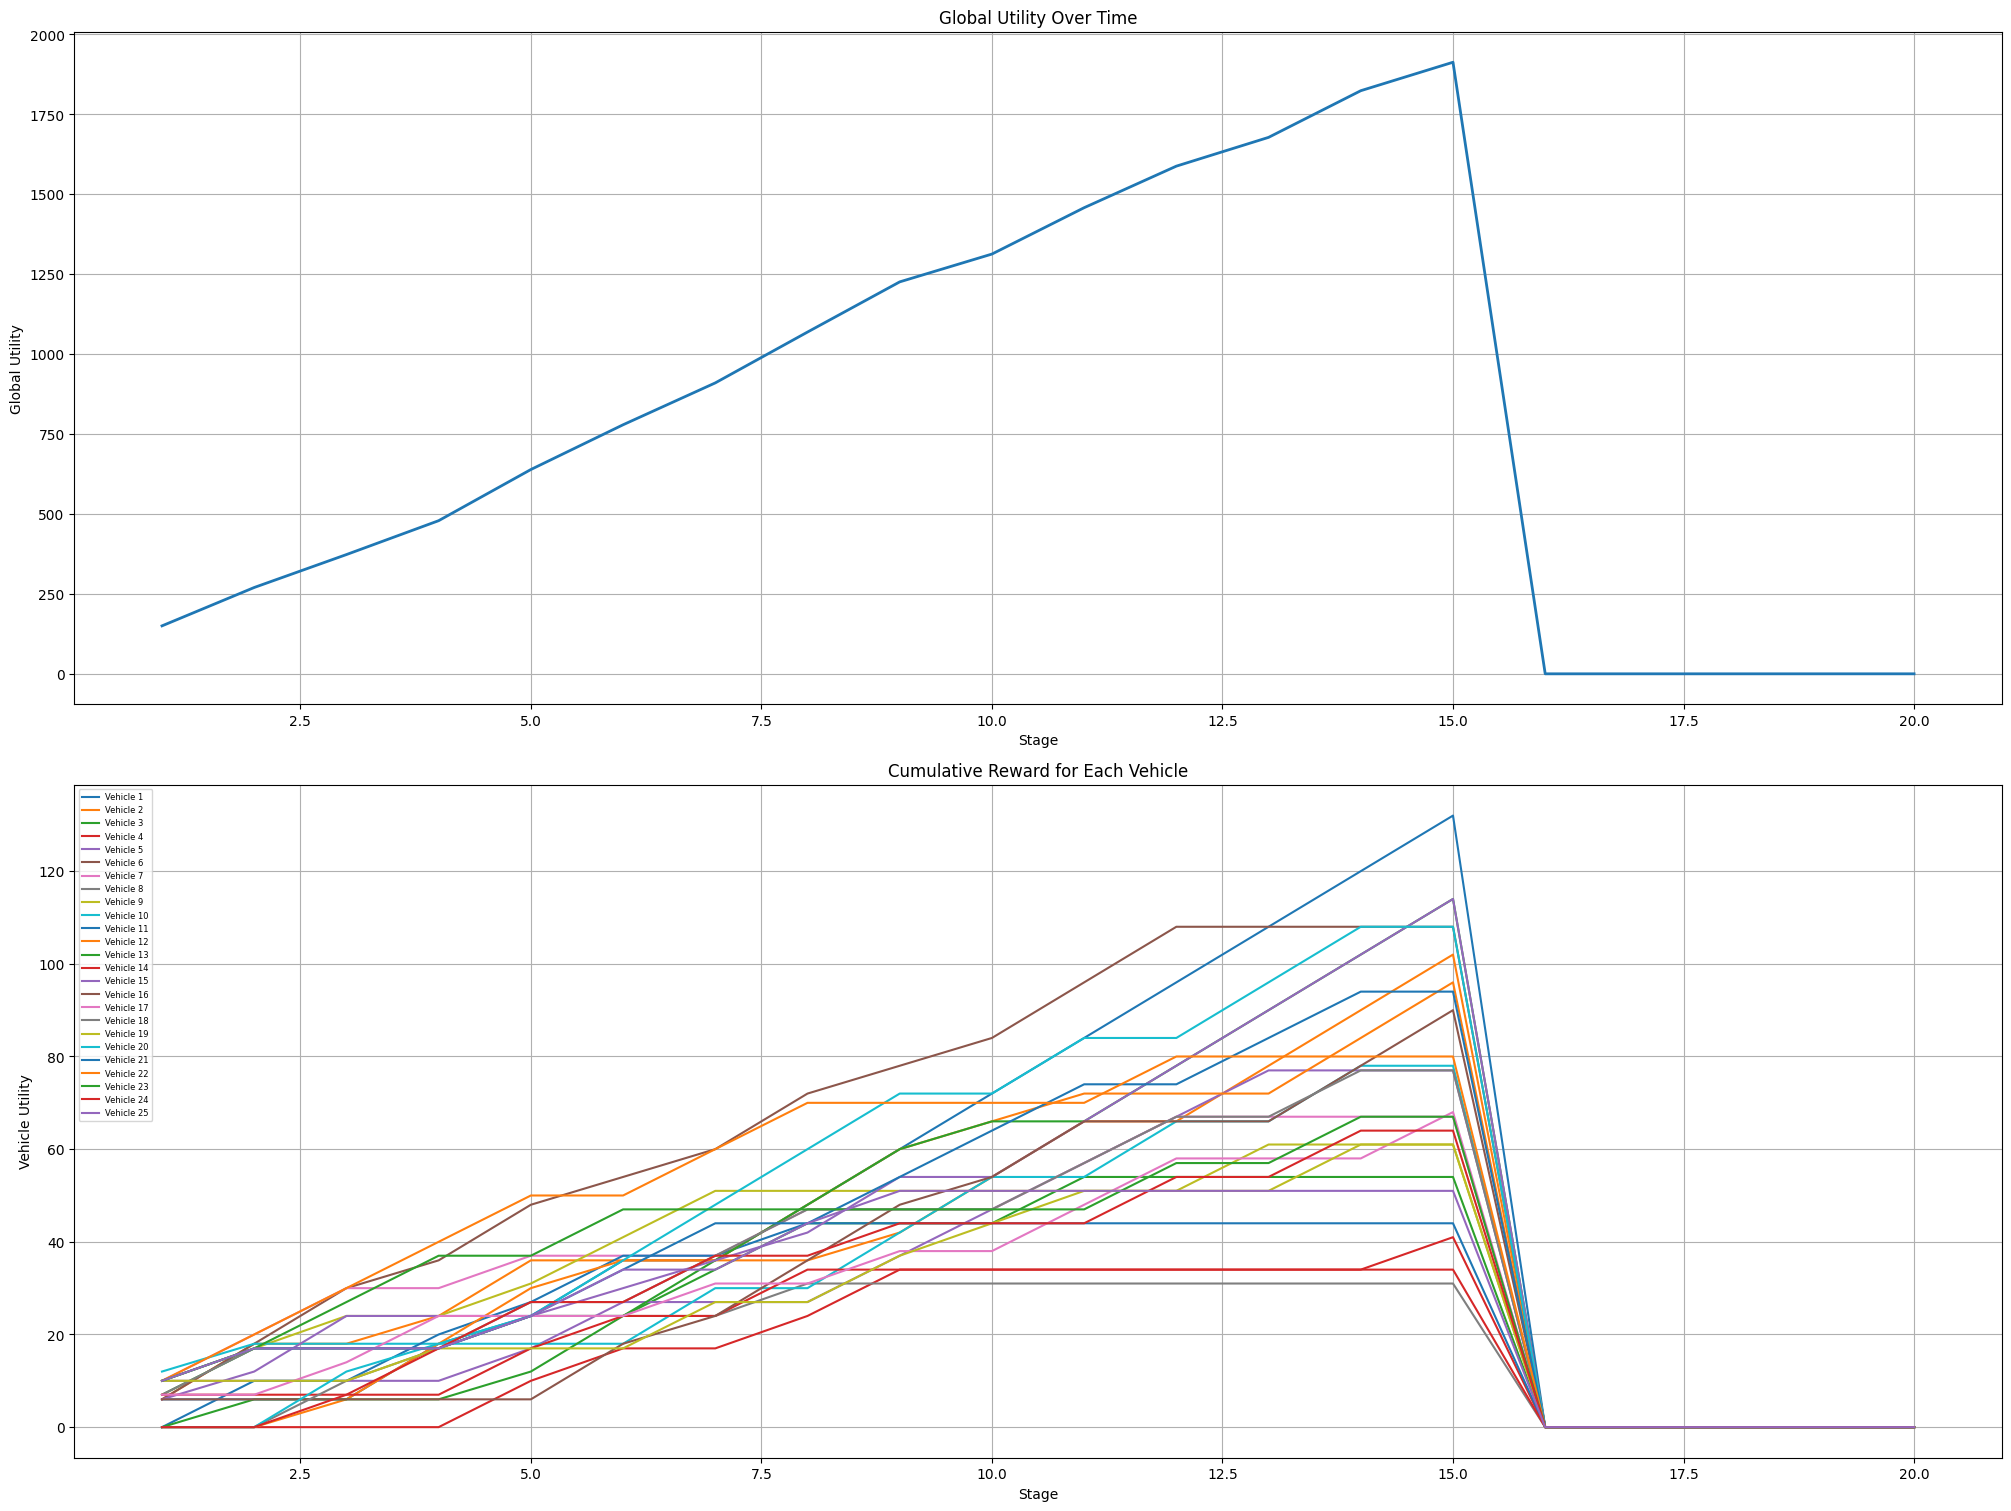

In [22]:
# Plotting Function
def plot_results(global_utility, vehicle_utility, H):
    """Plot global utility and vehicle utilities."""
    plt.figure(figsize=(20, 15), constrained_layout=True)  # Use constrained_layout for better spacing

    # Global Utility Plot
    plt.subplot(2, 1, 1)
    plt.plot(range(1, H + 1), global_utility[:H], linewidth=2)
    plt.xlabel("Stage")
    plt.ylabel("Global Utility")
    plt.title("Global Utility Over Time")
    plt.grid(True)

    # Vehicle Utility Plot
    plt.subplot(2, 1, 2)
    for i in range(vehicle_utility.shape[0]):
        plt.plot(range(1, H + 1), vehicle_utility[i, :H], label=f"Vehicle {i + 1}")
    plt.xlabel("Stage")
    plt.ylabel("Vehicle Utility")
    plt.title("Cumulative Reward for Each Vehicle")
    plt.legend(loc=2, prop={'size': 6})
    plt.grid(True)

    plt.show()

# Call the plot function
plot_results(global_utility, vehicle_utility, H)